In [1]:
import os

import h5py
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

In [2]:
import phate

In [3]:
os.chdir('..')
import manifold_methods
import plotting
import mappings
import data_loader

In [4]:
exp_path = '/lustre06/project/6065672/shared/DietNet/1KGB_POP24/1KGP/WGS30X_V1/oldnow/MattsPlace'
fname = '1000G.2504_WGS30x.GSA17k_MHI.intersectGSA.miss10perc.maf0.05.pruned.autosomes.noHLA.phased_imputed_V1.hdf5'

In [5]:
with h5py.File(os.path.join(exp_path, fname), 'r') as hf:
    #model_attrs = hf['gradients'][:]
    #print('loaded gradient of fc1 w.r.t. input from {}'.format(attr_fc1_saliency_name))
    inputs = hf['inputs'][:]
    class_label_names = hf['class_label_names'][:]
    class_labels = hf['class_labels'][:]
    samples = hf['samples'][:]
    snp_names = hf['snp_names'][:]

In [6]:
label_with_names = [str(class_label_names[y])[2:-1] for y in class_labels]

In [7]:
label_with_superpop_names = np.zeros_like(label_with_names)
for label in mappings.super_pops_1000G:
    index = pd.DataFrame(label_with_names).isin(mappings.super_pops_1000G[label]).values.flatten()
    label_with_superpop_names[index] = label

In [8]:
def plot_embeddings_1000G_labels(emb, labels, palette, label_order, ax):
    
    sns.scatterplot(x=emb[:,0],
                    y=emb[:,1],
                    ax=ax,
                    palette=palette,
                    hue_order=label_order,
                    hue=pd.Categorical(labels))
    ax.legend(bbox_to_anchor=(1.1, 1.05), loc='upper left')

    for label in np.unique(labels):
        index = label == labels
        mean_pos = emb[index,:2].mean(0)
        ax.text(x=mean_pos[0], 
                y=mean_pos[1], 
                s=label)

## PHATE Defaults

Running PHATE on 2322 observations and 229986 variables.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 57.31 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.33 seconds.
  Calculating affinities...
  Calculated affinities in 0.04 seconds.
Calculated graph and diffusion operator in 57.68 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.47 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.40 seconds.
Calculated landmark operator in 2.42 seconds.
Calculating optimal t...
  Automatically selected t = 22
Calculated optimal t in 1.76 seconds.


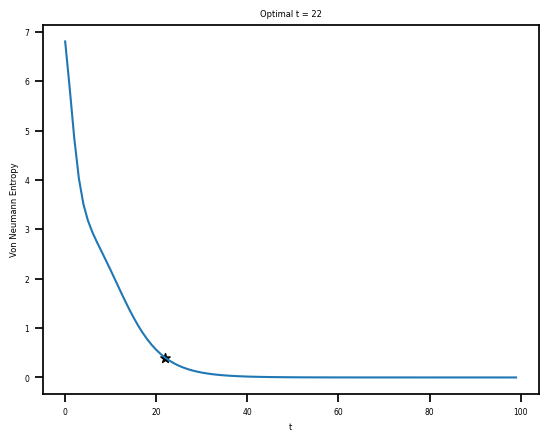

Calculating diffusion potential...
Calculated diffusion potential in 1.25 seconds.
Calculating metric MDS...
Calculated metric MDS in 2.76 seconds.


In [9]:
# initial phate embedding
phate_operator75 = phate.PHATE(random_state=75)
phate_operator75.fit(inputs)
phate_emb75 = phate_operator75.transform(plot_optimal_t=True)

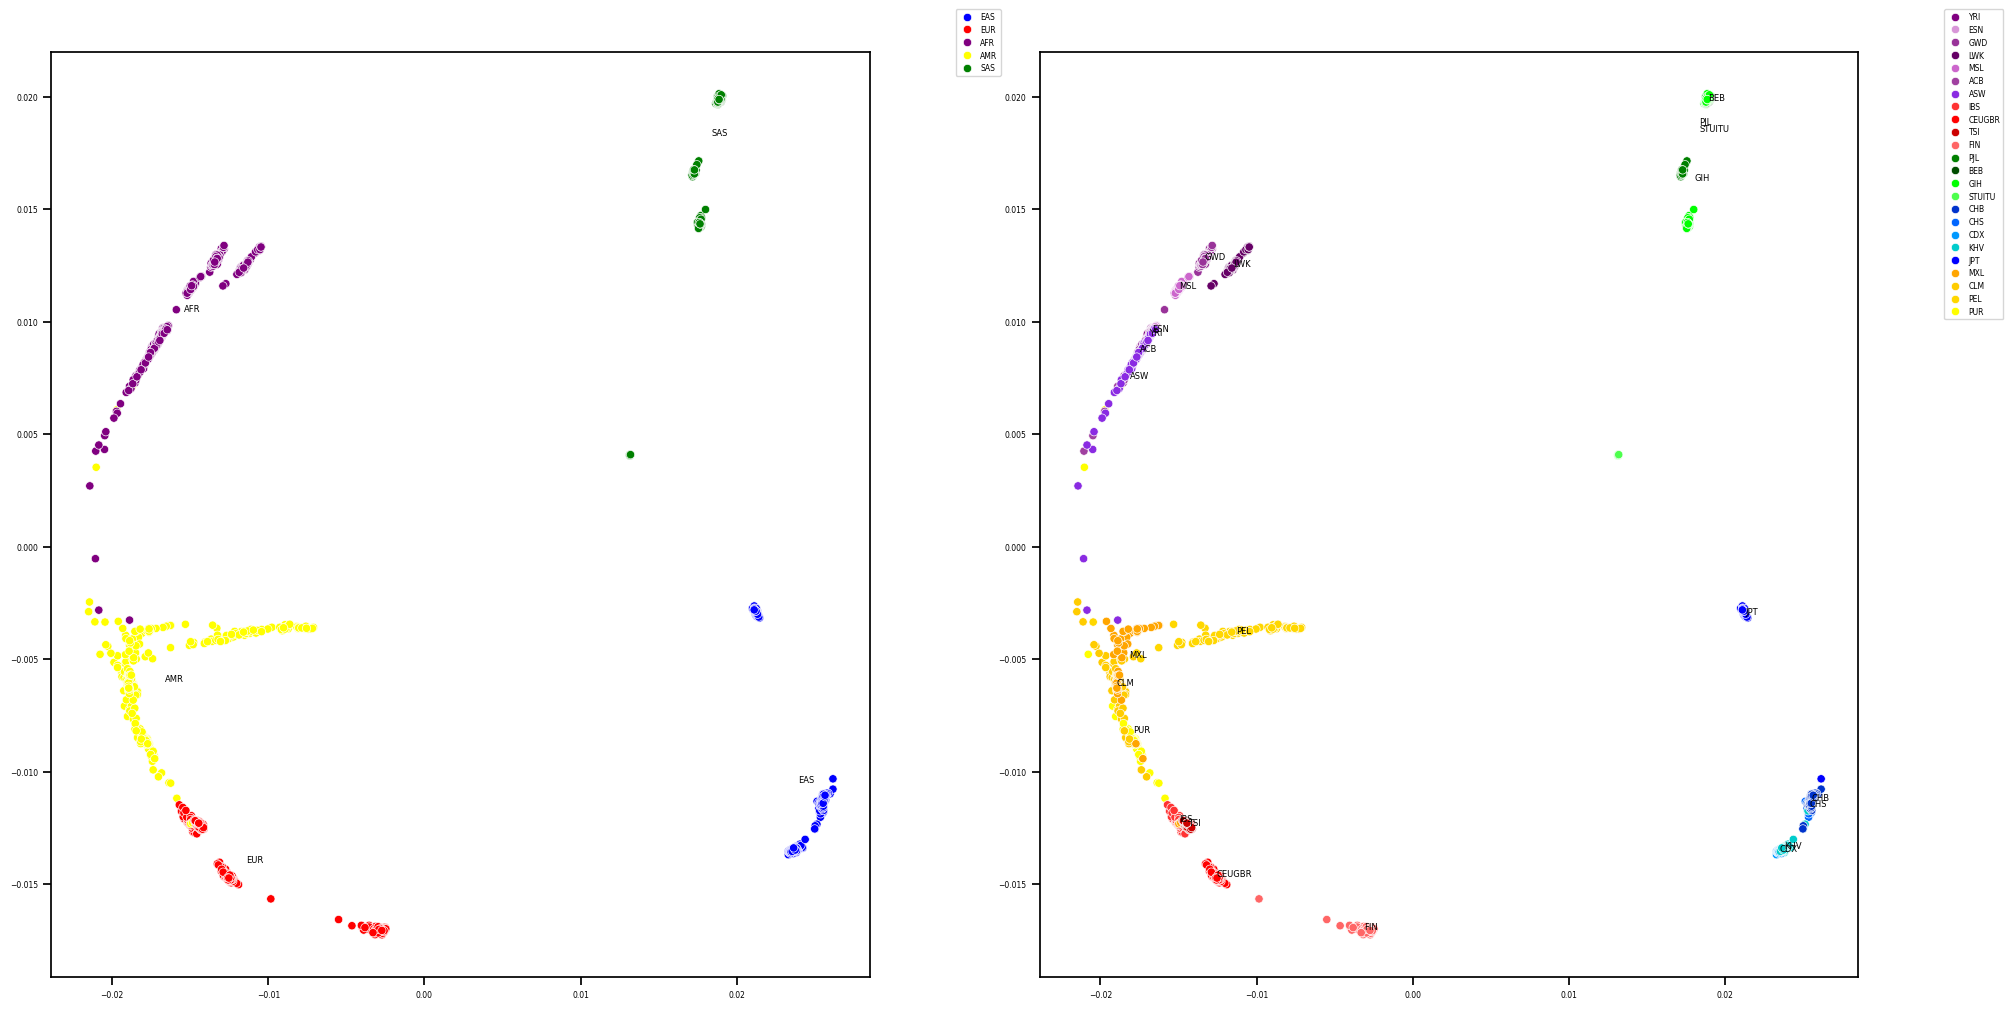

In [10]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))
plot_embeddings_1000G_labels(phate_emb75, 
                             np.array(label_with_superpop_names), 
                             mappings.pop_pallette_1000G_coarse,
                             mappings.label_order_1000G_coarse,
                             ax[0])
plot_embeddings_1000G_labels(phate_emb75, 
                             np.array(label_with_names),
                             mappings.pop_pallette_1000G_fine,
                             mappings.label_order_1000G_fine,
                             ax[1])
plt.tight_layout() 

## Default Again

Running PHATE on 2322 observations and 229986 variables.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 57.01 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.32 seconds.
  Calculating affinities...
  Calculated affinities in 0.04 seconds.
Calculated graph and diffusion operator in 57.37 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.13 seconds.
  Calculating KMeans...
  Calculated KMeans in 0.98 seconds.
Calculated landmark operator in 1.66 seconds.
Calculating optimal t...
  Automatically selected t = 6
Calculated optimal t in 1.84 seconds.


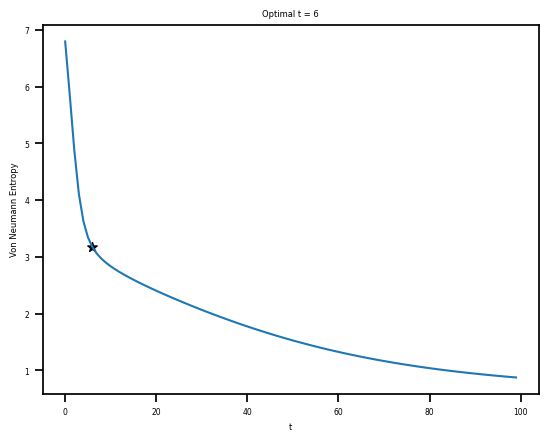

Calculating diffusion potential...
Calculated diffusion potential in 0.63 seconds.
Calculating metric MDS...
Calculated metric MDS in 2.72 seconds.


In [11]:
# initial phate embedding
phate_operator42 = phate.PHATE(random_state=42)
phate_operator42.fit(inputs)
phate_emb42 = phate_operator42.transform(plot_optimal_t=True)

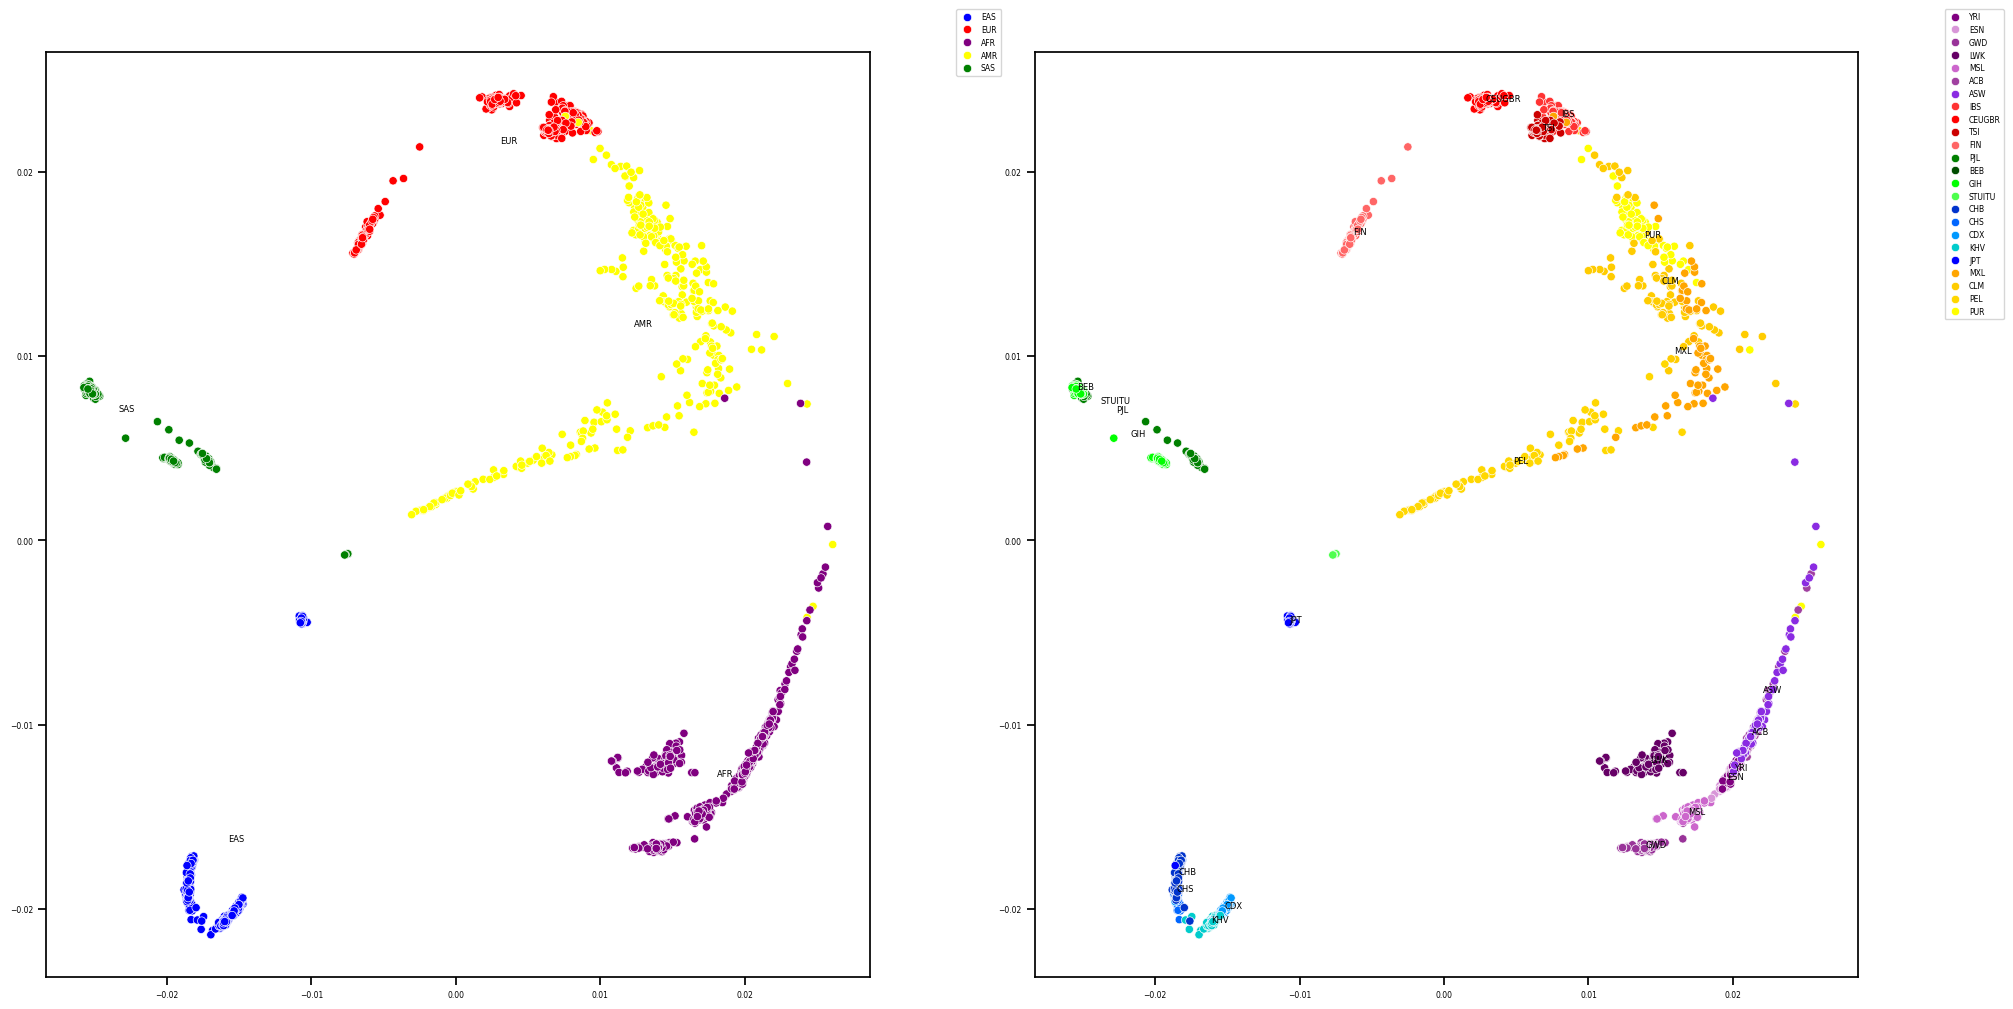

In [12]:
fig, ax = plt.subplots(ncols=2, figsize=(20,10))
plot_embeddings_1000G_labels(phate_emb42, 
                             np.array(label_with_superpop_names), 
                             mappings.pop_pallette_1000G_coarse,
                             mappings.label_order_1000G_coarse,
                             ax[0])
plot_embeddings_1000G_labels(phate_emb42, 
                             np.array(label_with_names),
                             mappings.pop_pallette_1000G_fine,
                             mappings.label_order_1000G_fine,
                             ax[1])
plt.tight_layout()

## Find random seed effect

In [13]:
from scipy.spatial.distance import pdist
from scipy.spatial.distance import squareform
from scipy.stats import pearsonr
import copy


<Axes: >

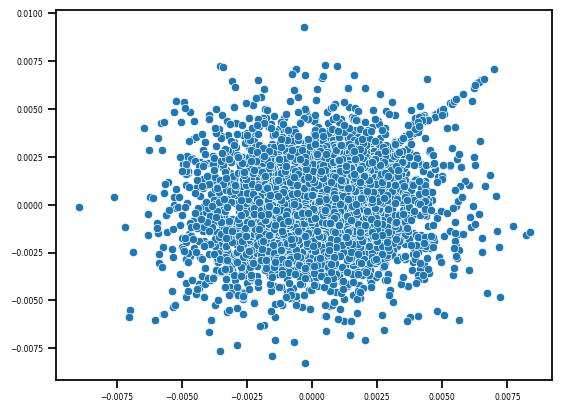

In [14]:
np.allclose(phate_operator42.X, phate_operator75.X)
r_idx = np.random.choice(np.prod(phate_operator75.graph.data_pca.components_.shape), 5000, replace=False)
sns.scatterplot(x=phate_operator75.graph.data_pca.components_.flatten()[r_idx], 
                y=phate_operator42.graph.data_pca.components_.flatten()[r_idx])

In [15]:
pearsonr(phate_operator75.graph.data_pca.components_.flatten()[r_idx], 
         phate_operator42.graph.data_pca.components_.flatten()[r_idx])

PearsonRResult(statistic=0.1561199155701363, pvalue=1.189648928310293e-28)

In [16]:
pcs_75 = phate_operator75.graph.data_pca.transform(phate_operator75.graph.data)
pcs_42 = phate_operator42.graph.data_pca.transform(phate_operator42.graph.data)
np.allclose(phate_operator75.graph.data_nu, pcs_75) # these are the same!
np.allclose(phate_operator42.graph.data_nu, pcs_42)

True

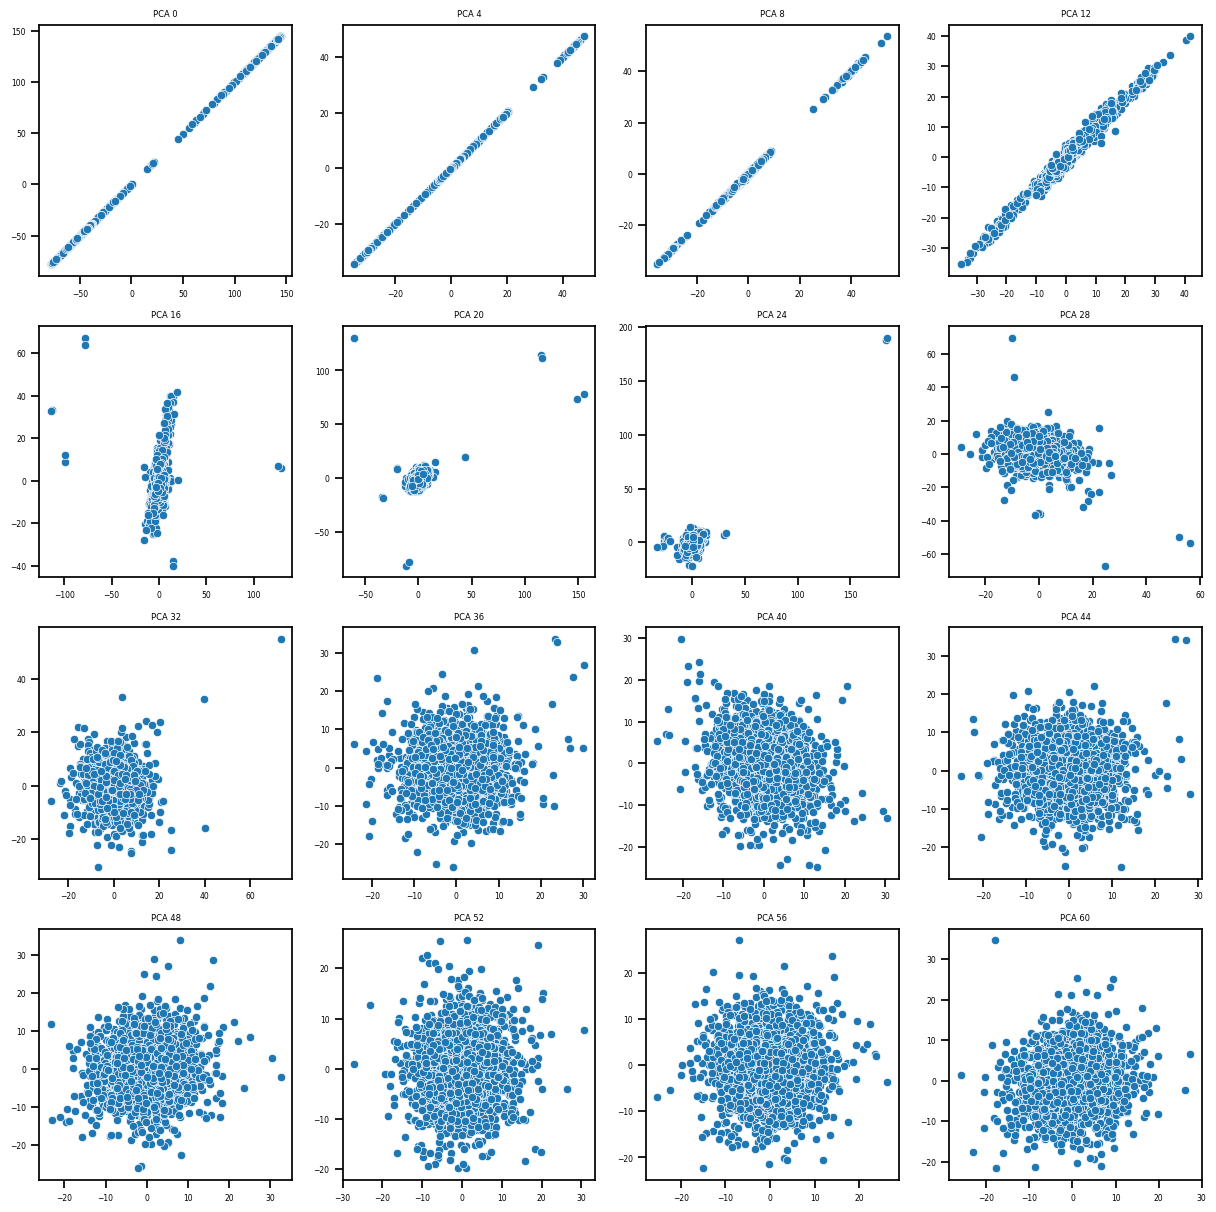

In [17]:
fig, ax = plt.subplots(nrows=4, ncols=4, figsize=(15,15))

k = 0
for i in range(4):
    for j in range(4):
        sns.scatterplot(x=pcs_42[:,k], 
                        y=pcs_75[:,k],
                        ax=ax[i,j])
        ax[i,j].set_title('PCA {}'.format(k))
        k += 4 # increment more

In [18]:
dists_42 = pdist(pcs_42)
dists_75 = pdist(pcs_75)

In [19]:
r_idx = np.random.choice(dists_42.shape[0], 10000, replace=False)

Text(0, 0.5, 'PCA Distances for random seed = 75')

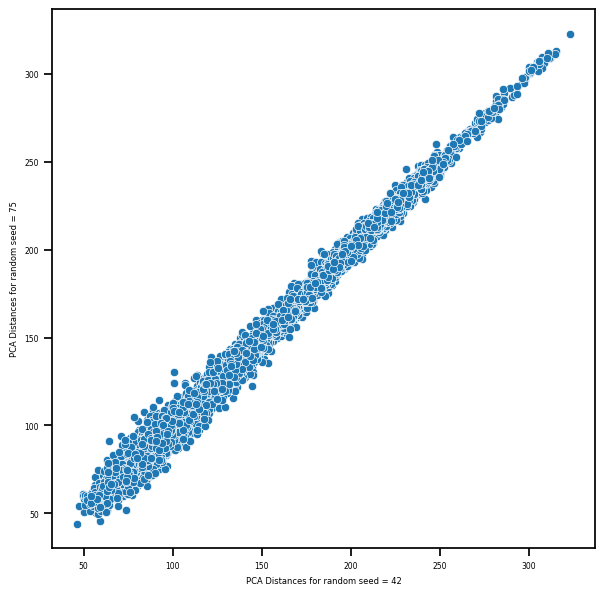

In [20]:
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(x=dists_42[r_idx], 
                y=dists_75[r_idx],
                ax=ax)
ax.set_xlabel('PCA Distances for random seed = 42')
ax.set_ylabel('PCA Distances for random seed = 75')

In [21]:
dists_42_5perc = np.percentile(dists_42, 1)
dists_75_5perc = np.percentile(dists_75, 1)
smallest_dists = (dists_42 <= dists_42_5perc) | (dists_75 <= dists_75_5perc)

Text(0, 0.5, 'PCA Distances for random seed = 75')

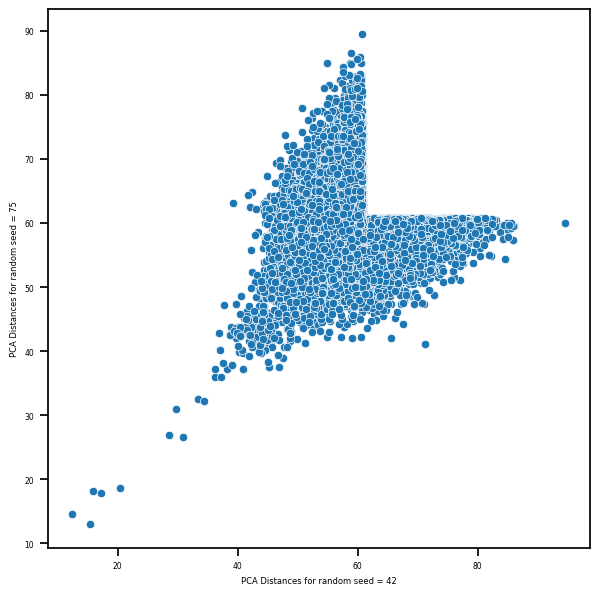

In [22]:
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(x=dists_42[smallest_dists], 
                y=dists_75[smallest_dists])
ax.set_xlabel('PCA Distances for random seed = 42')
ax.set_ylabel('PCA Distances for random seed = 75')

## Looking at nearest neighbours

In [23]:
dist_mat_42 = squareform(dists_42)
dist_mat_75 = squareform(dists_75)

In [24]:
pca_neighbours_42 = np.argsort(dist_mat_42, axis=1)
pca_neighbours_75 = np.argsort(dist_mat_75, axis=1)

In [25]:
def get_overlap(x, y):
    return len(set(x).intersection(y))/len(x)

In [26]:
overlaps = np.array([get_overlap(pca_neighbours_42[i,1:31], pca_neighbours_75[i,1:31]) for i in range(len(pca_neighbours_75))])

In [27]:
print(overlaps.mean()) # share 30% top 30 nearest neighbours

0.37141831754234855


## Looking at similarity of Alpha Kernel (with decay) Values

In [28]:
K_42 = phate_operator42.graph.K.todense()
K_75 = phate_operator75.graph.K.todense()

K_42_mat = squareform(K_42-np.diag(np.ones(phate_operator42.graph.K.shape[0])))
K_75_mat = squareform(K_75-np.diag(np.ones(phate_operator42.graph.K.shape[0])))

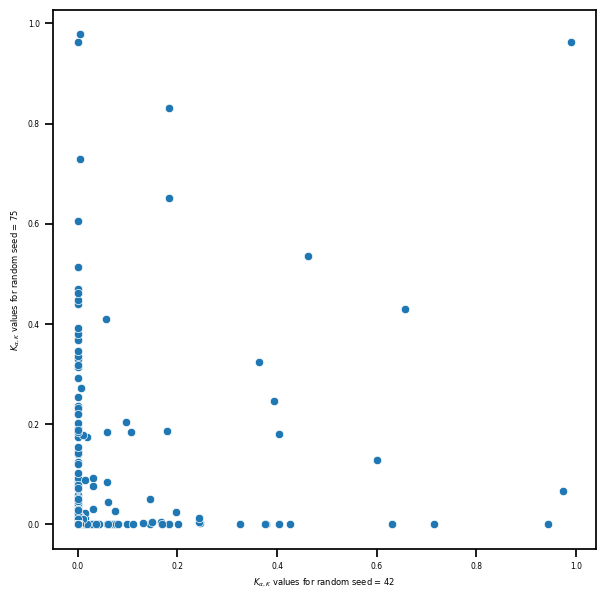

In [29]:
r_idx = np.random.choice(K_75_mat.shape[0], 10000, replace=False)

fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(x=K_42_mat[r_idx], 
                y=K_75_mat[r_idx],
                ax=ax)
_ = ax.set_xlabel(r'$K_{\alpha,K}$ values for random seed = 42')
_ = ax.set_ylabel(r'$K_{\alpha,K}$ values for random seed = 75')

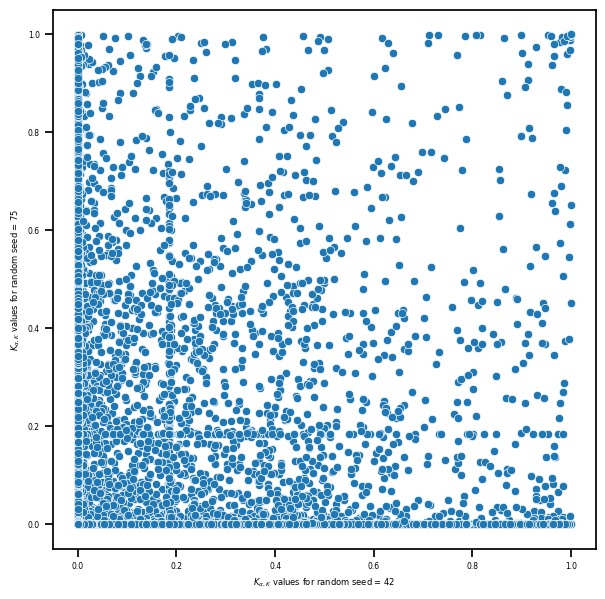

In [30]:
fig, ax = plt.subplots(figsize=(7,7))
sns.scatterplot(x=K_42_mat[smallest_dists], 
                y=K_75_mat[smallest_dists],
                ax=ax)
_ = ax.set_xlabel(r'$K_{\alpha,K}$ values for random seed = 42')
_ = ax.set_ylabel(r'$K_{\alpha,K}$ values for random seed = 75')

## Adjust t

In [34]:
phate_operator = phate.PHATE(random_state=75)
phate_operator.fit(inputs)

Running PHATE on 2322 observations and 229986 variables.
Calculating graph and diffusion operator...
  Calculating PCA...
  Calculated PCA in 57.14 seconds.
  Calculating KNN search...
  Calculated KNN search in 0.33 seconds.
  Calculating affinities...
  Calculated affinities in 0.03 seconds.
Calculated graph and diffusion operator in 57.51 seconds.
Calculating landmark operator...
  Calculating SVD...
  Calculated SVD in 0.13 seconds.
  Calculating KMeans...
  Calculated KMeans in 1.76 seconds.
Calculated landmark operator in 2.45 seconds.


PHATE(random_state=75)

In [35]:
phate_embs = []
for t in [5, 10, 25, 50, 100, 200]:
    phate_operator.set_params(t=t)
    phate_embs.append(phate_operator.transform())

Calculating diffusion potential...
Calculated diffusion potential in 0.64 seconds.
Calculating metric MDS...
Calculated metric MDS in 2.71 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 0.84 seconds.
Calculating metric MDS...
Calculated metric MDS in 2.72 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 1.25 seconds.
Calculating metric MDS...
Calculated metric MDS in 2.71 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 1.45 seconds.
Calculating metric MDS...
Calculated metric MDS in 2.72 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 1.66 seconds.
Calculating metric MDS...
Calculated metric MDS in 2.72 seconds.
Calculating diffusion potential...
Calculated diffusion potential in 1.86 seconds.
Calculating metric MDS...
Calculated metric MDS in 2.72 seconds.


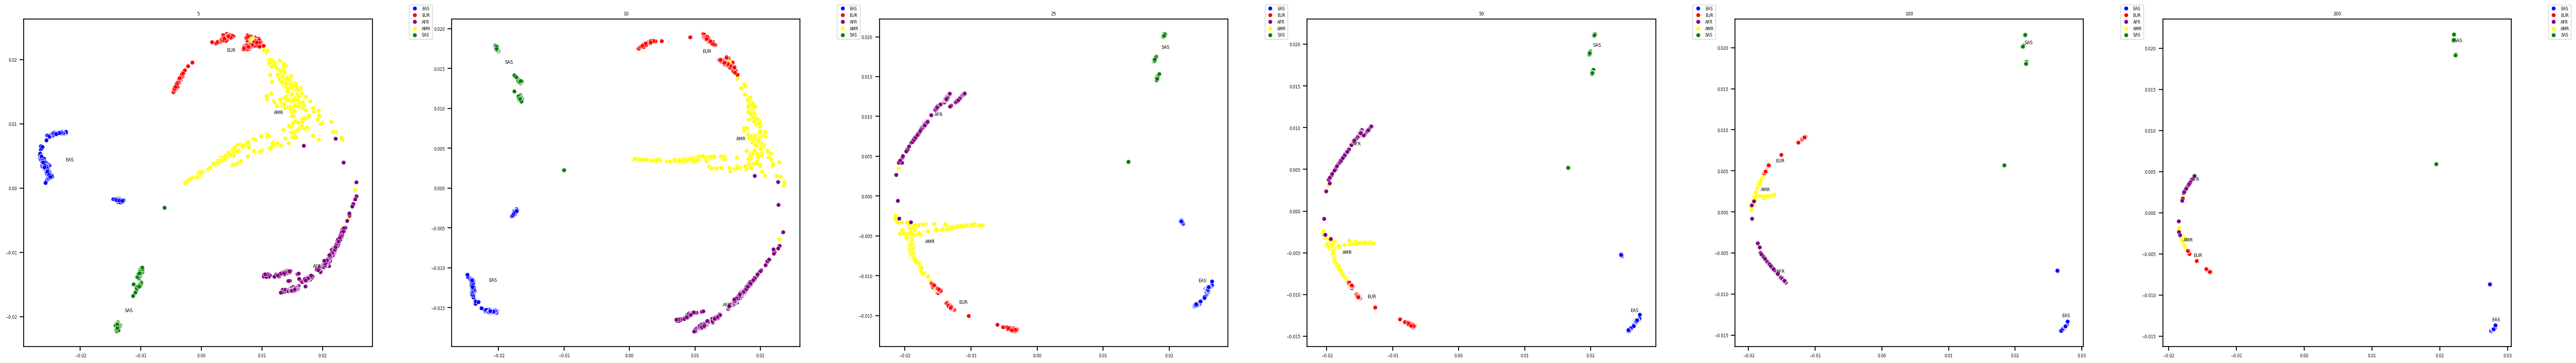

In [36]:
fig, ax = plt.subplots(ncols=6, figsize=(50,7))
for i,t in enumerate([5, 10, 25, 50, 100, 200]):
    plot_embeddings_1000G_labels(phate_embs[i], 
                                 np.array(label_with_superpop_names), 
                                 mappings.pop_pallette_1000G_coarse,
                                 mappings.label_order_1000G_coarse,
                                 ax[i])
    ax[i].set_title(t)
plt.tight_layout()